In [ ]:
using Pkg
Pkg.add("DataFrames");
Pkg.add("CSV");
Pkg.add("GLM");
Pkg.add("Statistics");
Pkg.add("StatsBase");
Pkg.add("StatsPlots");
Pkg.add("Gadfly");

In [80]:
ENV["COLUMNS"] = 150 # Permet de voir plus de colonnes des dataframes
using CSV, DataFrames, GLM, Statistics, StatsBase, Random, Gadfly, Distributions;

# Spacehip titanic

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

## Data

* train.csv : Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
    * PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
    * HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
    *CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
    * Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
    * Destination - The planet the passenger will be debarking to.
    * Age - The age of the passenger.
    * VIP - Whether the passenger has paid for special VIP service during the voyage.
    RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
    * Name - The first and last names of the passenger.
    * Transported - Whether the passenger was transported to another dimension. This is the target, the **column you are trying to predict.**

* test.csv : Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
* sample_submission.csv - A submission file in the correct format.
    * PassengerId - Id for each passenger in the test set.
    * Transported - The target. For each passenger, predict either True or False.

###  Loading data

In [124]:
data = CSV.read("spaceship-titanic/train.csv", DataFrame);
first(data, 15)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
,String7,String7?,Bool?,String15?,String15?,Float64?,Bool?,Float64?,Float64?,Float64?,Float64?,Float64?,String31?
1,0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
2,0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines
3,0003_01,Europa,0,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
4,0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
5,0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines
6,0005_01,Earth,0,F/0/P,PSO J318.5-22,44.0,0,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews
7,0006_01,Earth,0,F/2/S,TRAPPIST-1e,26.0,0,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey
8,0006_02,Earth,1,G/0/S,TRAPPIST-1e,28.0,0,0.0,0.0,0.0,0.0,missing,Candra Jacostaffey
9,0007_01,Earth,0,F/3/S,TRAPPIST-1e,35.0,0,0.0,785.0,17.0,216.0,0.0,Andona Beston


### Exploratory analysis

In [125]:
function check_missing(df::DataFrame)
    """
    Print le nombre de valeurs manquantes par colonne
    @params:
        - df: DataFrame à analyser
    """
    number_datapoint = nrow(df)
    println("Number of data: $number_datapoint \n")
    for i in 1:size(df,2)
        nb_missing = count(ismissing.(df[:, i]))
        var_name = names(df)[i]
        
        println("$var_name - missing: $nb_missing")
    end
end

check_missing(data)

Number of data: 8693 

PassengerId - missing: 0
HomePlanet - missing: 201
CryoSleep - missing: 217
Cabin - missing: 199
Destination - missing: 182
Age - missing: 179
VIP - missing: 203
RoomService - missing: 181
FoodCourt - missing: 183
ShoppingMall - missing: 208
Spa - missing: 183
VRDeck - missing: 188
Name - missing: 200
Transported - missing: 0


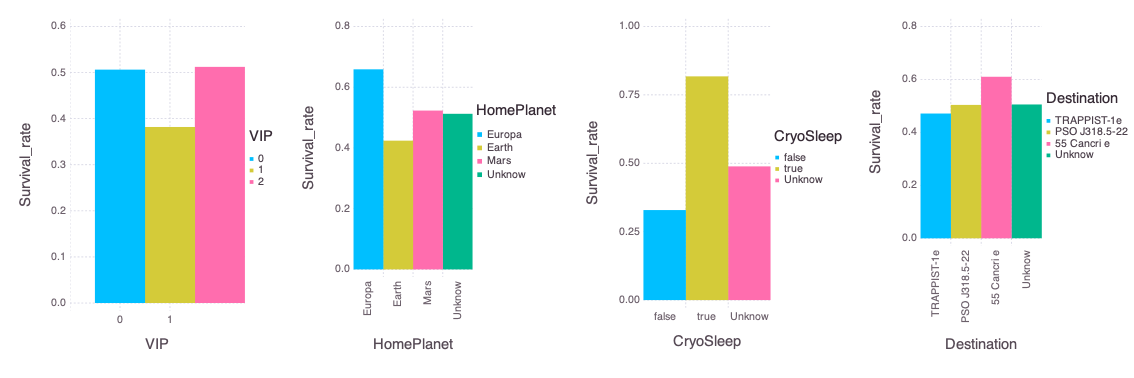

In [127]:
df = data

Gadfly.set_default_plot_size(30cm, 10cm)

df.VIP = replace(df.VIP, missing => 2)
p1 = plot(combine(groupby(data, :VIP), :Transported => mean => :Survival_rate), x=:VIP, y=:Survival_rate, Geom.bar, Guide.xticks(ticks=0:1:2), color=:VIP)
df[!, :VIP] = string.(data[:, :VIP]); # For GLM to use this as classes

df.HomePlanet = replace(df.HomePlanet, missing => "Unknow")
p2 = plot(combine(groupby(data, :HomePlanet), :Transported => mean => :Survival_rate), x=:HomePlanet, y=:Survival_rate, Geom.bar, color=:HomePlanet)

df.CryoSleep = replace(df.CryoSleep, missing => "Unknow")
p3 = plot(combine(groupby(data, :CryoSleep), :Transported => mean => :Survival_rate), x=:CryoSleep, y=:Survival_rate, Geom.bar, color=:CryoSleep)
df[!, :CryoSleep] = string.(data[:, :CryoSleep]); # For GLM to use this as classes

df.Destination = replace(df.Destination, missing => "Unknow")
p4 = plot(combine(groupby(data, :Destination), :Transported => mean => :Survival_rate), x=:Destination, y=:Survival_rate, Geom.bar, color=:Destination)

df.RoomService = replace(df.RoomService, missing => mean(skipmissing(df.RoomService)))
df.Age = replace(df.Age, missing => mean(skipmissing(df.Age)))
df.FoodCourt = replace(df.FoodCourt, missing => mean(skipmissing(df.FoodCourt)))
df.ShoppingMall = replace(df.ShoppingMall, missing => mean(skipmissing(df.ShoppingMall)))
df.Spa = replace(df.Spa, missing => mean(skipmissing(df.Spa)))
df.VRDeck = replace(df.VRDeck, missing => mean(skipmissing(df.VRDeck)))

hstack(p1, p2, p3, p4)

In [128]:
check_missing(df)
df

Number of data: 8693 

PassengerId - missing: 0
HomePlanet - missing: 0
CryoSleep - missing: 0
Cabin - missing: 199
Destination - missing: 0


Age - missing: 0
VIP - missing: 0
RoomService - missing: 0
FoodCourt - missing: 0
ShoppingMall - missing: 0
Spa - missing: 0
VRDeck - missing: 0
Name - missing: 200
Transported - missing: 0


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
,String7,String,String,String15?,String,Float64,String,Float64,Float64,Float64,Float64,Float64,String31?
1,0001_01,Europa,false,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
2,0002_01,Earth,false,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines
3,0003_01,Europa,false,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
4,0003_02,Europa,false,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
5,0004_01,Earth,false,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines
6,0005_01,Earth,false,F/0/P,PSO J318.5-22,44.0,0,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews
7,0006_01,Earth,false,F/2/S,TRAPPIST-1e,26.0,0,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey
8,0006_02,Earth,true,G/0/S,TRAPPIST-1e,28.0,0,0.0,0.0,0.0,0.0,304.855,Candra Jacostaffey
9,0007_01,Earth,false,F/3/S,TRAPPIST-1e,35.0,0,0.0,785.0,17.0,216.0,0.0,Andona Beston


## Maximum likelihood estimation of the logistic regression model

In [134]:
# M = glm(@formula(Transported ~ HomePlanet + CryoSleep + Cabin + Destination + Age + VIP + RoomService + FoodCourt + ShoppingMall + Spa + VRDeck ), df,  Bernoulli(), LogitLink())

M = glm(@formula(Transported ~ HomePlanet + CryoSleep + Destination + Age + VIP + RoomService + FoodCourt + ShoppingMall + Spa + VRDeck), df,  Bernoulli(), LogitLink())


StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Bernoulli{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Transported ~ 1 + HomePlanet + CryoSleep + Destination + Age + VIP + RoomService + FoodCourt + ShoppingMall + Spa + VRDeck

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────────────
                                   Coef.   Std. Error       z  Pr(>|z|)     Lower 95%     Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                  0.557025     0.186211       2.99    0.0028   0.192057      0.921993
HomePlanet: Europa           2.15744      0.116806      18.47    <1e-75   1.92851       2.38638
HomePlanet: Mars             0.697117     0.0765905      9.10    <1e-19   0.547002      0.847231
HomePlanet: Unknow           0.57608